# Vehicle Detection Project
The goals/steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

**Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.**

In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
from vehicle_detection.constants import *

In [3]:
from vehicle_detection.helpers import load_images
cars, not_cars = load_images()
print(cars[0].shape)
print(not_cars[0].shape)

(64, 64, 3)
(64, 64, 3)


## Feature Extraction and Classifier Training
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [4]:
from skimage.feature import hog

def get_hog_features(img, orientation, pixel_per_cell, cell_per_block, visualization, feature_vector):
    return hog(img, orientations=orientation,
              pixels_per_cell=(pixel_per_cell, pixel_per_cell),
              cells_per_block=(cell_per_block, cell_per_block),
              visualise=visualization, feature_vector=feature_vector,
              block_norm="L2-Hys")

def normalize_features(X_train, X_test):
    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test, X_scaler

from sklearn import svm
from sklearn.model_selection import GridSearchCV

def get_classifier(X_train, y_train):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    classifier = GridSearchCV(svc, parameters, n_jobs=6, verbose=5)
    classifier.fit(X_train, y_train)
    return classifier

## Color Transformation and More Color Features
Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

In [5]:
import numpy as np

def bin_centers(histogram):
    bin_edges = histogram[1]
    return (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2

def histogram_features(img, bins=32):
    histograms_per_channel = [np.histogram(img[:, :, i], bins=bins) for i in range(img.shape[2])]
    histogram_features_per_channel = [h[0] for h in histograms_per_channel]
    return np.concatenate(histogram_features_per_channel)

import cv2

def bin_spatial(img, new_size=(32, 32)):
    return cv2.resize(img, new_size).ravel()

from sklearn.preprocessing import StandardScaler

def configure_single_image_features(color_space='RGB', spatial_size=(32, 32), histogram_bins=32, orientation=9, pixel_per_cell=8,
                              cell_per_block=2, hog_channel=0, spatial_feature=False, histogram_feature=False, hog_feature=False):
    def single_image_features_method(img):
        img_features = []
        if color_space != 'RGB':
            img = cv2.cvtColor(img, COLOR_CONVERSION_CONSTANTS[color_space])
        if spatial_feature:
            img_features.append(bin_spatial(img, new_size=spatial_size))
        if histogram_feature:
            img_features.append(histogram_features(img, histogram_bins))
        if hog_feature:
            if hog_channel == 'ALL':
                hog_features_per_channel = [get_hog_features(img[:, :, c], orientation, pixel_per_cell, cell_per_block, visualization=False, feature_vector=True)
                                            for c in range(img.shape[2])]
                hog_features = [h for hogs in hog_features_per_channel for h in hogs]
            else:
                hog_features = get_hog_features(img[:, :, hog_channel], orientation, pixel_per_cell, cell_per_block,
                                                visualization=False, feature_vector=True)
            img_features.append(hog_features)

        return np.concatenate(img_features)
    
    return single_image_features_method

single_image_features = configure_single_image_features(color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, histogram_bins=HISTOGRAM_BINS, orientation=ORIENTATION,
                                                        pixel_per_cell=PIXEL_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                                                        spatial_feature=SPATIAL_FEATURE, histogram_feature=HISTOGRAM_FEATURE, hog_feature=HOG_FEATURE)

print(np.array(single_image_features(cars[0])).astype(np.float64))

[  0.63954514   0.48019257   0.49649656 ...,   0.          10.60185423
  35.86337451]


### Extract Features

In [6]:
car_features = [single_image_features(i) for i in cars]
not_car_features = [single_image_features(i) for i in not_cars]

## Sliding-window Search with Classifier
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [7]:
print(len(car_features), len(not_car_features))
print(np.array(car_features[0:1]).shape)
print(np.concatenate((not_car_features[0:1], car_features[0:1])).shape)
car_features_shapes = [c.shape for c in car_features if len(c.shape) != 1]
not_car_features_shapes = [c.shape for c in not_car_features if len(c.shape) != 1]
print(car_features_shapes[0:5], not_car_features_shapes[0:5])
print(car_features[0])
print(np.array(car_features[0:1]).astype(np.float64))

8792 8968
(1, 6108)
(2, 6108)
[] []
[  0.63954514   0.48019257   0.49649656 ...,   0.          10.60185423
  35.86337451]
[[  0.63954514   0.48019257   0.49649656 ...,   0.          10.60185423
   35.86337451]]


In [8]:
from sklearn.model_selection import train_test_split

def split_to_train_and_test(X, y, test_size):
    rand_state = np.random.randint(0, 100)
    return train_test_split(X, y, test_size=test_size, random_state=rand_state)

Xs = np.vstack((car_features, not_car_features)).astype(np.float64)
ys = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X_train, X_test, y_train, y_test = split_to_train_and_test(Xs, ys, 0.2)
X_train, X_test, X_scaler = normalize_features(X_train, X_test)
classifier = get_classifier(X_train, y_train)
print(classifier.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done   4 out of  12 | elapsed:  6.5min remaining: 12.9min
[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:  6.6min remaining:  4.7min
[Parallel(n_jobs=6)]: Done  10 out of  12 | elapsed:  9.7min remaining:  1.9min
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  9.9min finished


0.993524774775


In [44]:
from vehicle_detection.bounding_box import BoundingBox

def get_sliding_windows(image, start_point=(None, None), stop_point=(None, None), window=(64, 64), overlap_ratio=(0.5, 0.5)):
    def default_start_and_stop_point(image, st_pt, sp_pt):
        return (st_pt[0] or 0, st_pt[1] or 0), (sp_pt[0] or image.shape[1], sp_pt[1] or image.shape[0])

    start_point, stop_point = default_start_and_stop_point(image, start_point, stop_point)
    span = BoundingBox(start_point, stop_point).get_span()
    step = np.int_((window[0] * (1 - overlap_ratio[0]), window[1] * (1 - overlap_ratio[1])))
    number_of_windows = np.int_(((span[0] - window[0]) / step[0] + 1, (span[1] - window[1]) / step[1] + 1))
    window_list = []
    for x in range(number_of_windows[0]):
        for y in range(number_of_windows[1]):
            left_top = (start_point[0] + x * step[0], start_point[1] + y * step[1])
            right_bottom = (left_top[0] + window[0], left_top[1] + window[1])
            window_list.append((left_top, right_bottom))
            
    return window_list

def search_windows(image, windows, classfier, classifier_size, scaler, single_image_features_method):
    on_windows = []
    for w in windows:
        feature_image = cv2.resize(image[w[0][1]:w[1][1], w[0][0]:w[1][0]], classifier_size)
        features = single_image_features_method(feature_image)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = classfier.predict(test_features)
        if prediction == 1:
            on_windows.append(w)

    return on_windows

import matplotlib.image as mpimg
image = mpimg.imread('test_images/test3.jpg')
image = image.astype(np.float32) / 255
print(SLIDING_WINDOW_PARAMS)

import time
t1 = time.time()
sliding_window_in_groups = [get_sliding_windows(image, start_point=(None, x[0][0]), stop_point=(None, x[0][1]), window=x[1], overlap_ratio=x[2])
                            for x in SLIDING_WINDOW_PARAMS]
windows = [win for window_group in sliding_window_in_groups for win in window_group]
print(windows[0:10], len(windows))
hot_windows = search_windows(image, windows, classifier, (64, 64), X_scaler, single_image_features)
t2 = time.time()
print(hot_windows[0:10], len(hot_windows))
print(t2 - t1)

[((400, 464), (48, 48), (0.5, 0.5)), ((400, 528), (64, 64), (0.55000000000000004, 0.55000000000000004)), ((400, 592), (96, 96), (0.60000000000000009, 0.60000000000000009)), ((400, 656), (128, 128), (0.65000000000000013, 0.65000000000000013))]
[((0, 400), (48, 448)), ((24, 400), (72, 448)), ((48, 400), (96, 448)), ((72, 400), (120, 448)), ((96, 400), (144, 448)), ((120, 400), (168, 448)), ((144, 400), (192, 448)), ((168, 400), (216, 448)), ((192, 400), (240, 448)), ((216, 400), (264, 448))] 361
[] 0
5.4244890213012695


### Heatmap

In [45]:
def accumulate_heat(heatmap, bounding_boxes):
    for b in bounding_boxes:
        heatmap[b[0][1]:b[1][1], b[0][0]:b[1][0]] += 1
        
    return heatmap

def thresholding(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

heatmap = accumulate_heat(np.zeros_like(image[:, :, 0]).astype(np.float), hot_windows)
heatmap = thresholding(heatmap, 0)

### Visulizations

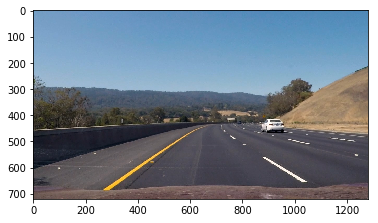

In [46]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 0, 1.0), thickness=4):
    copy = np.copy(image)
    for b in bounding_boxes:
        cv2.rectangle(copy, b[0], b[1], color, thickness)
    return copy

import matplotlib.pyplot as plt
%matplotlib inline
window_image = draw_bounding_boxes(image, hot_windows)
plt.imshow(window_image)

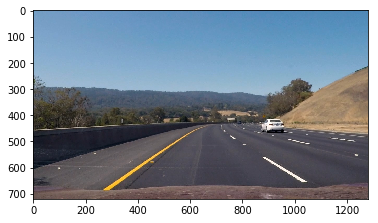

In [47]:
from scipy.ndimage.measurements import label

def draw_labeled_bounding_boxes(image, labels):
    bounding_boxes = []
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzerox, nonzeroy = np.array(nonzero[1]), np.array(nonzero[0])
        bounding_boxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    copy = draw_bounding_boxes(image, bounding_boxes)
    return copy

result_image = draw_labeled_bounding_boxes(image, label(heatmap))
plt.imshow(result_image)

## Pipeline Processing
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [43]:
def process_image_method(classifier, scaler, single_image_features_method, sliding_window_params, all_found_windows_per_search, window_cache_length, heatmap_threshold):

    def process_image(source):
        def find_hot_windows_for_image(source):
            sliding_window_groups = [get_sliding_windows(source, start_point=(None, x[0][0]), stop_point=(None, x[0][1]), window=x[1], overlap_ratio=(0.5, 0.5))
                                        for x in sliding_window_params]
            sliding_windows = [win for window_group in sliding_window_groups for win in window_group]
            return search_windows(source, sliding_windows, classifier, (64, 64), scaler, single_image_features_method)

        source = source.astype(np.float32) / 255
        detected_windows_in_source = find_hot_windows_for_image(source)
        all_found_windows_per_search.append(detected_windows_in_source)
        latest_windows = [w for group in all_found_windows_per_search[-window_cache_length:] for w in group]
        heat_map = thresholding(accumulate_heat(np.zeros_like(source[:, :, 0]).astype(np.float), latest_windows), heatmap_threshold)
#         result = draw_bounding_boxes(source, latest_windows)
        result = draw_labeled_bounding_boxes(source, label(heat_map))
        result = (result * 255).astype(np.uint8)
        return result
    
    return process_image

single_image_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], 1, 2)

import glob
test_image_files = glob.glob('test_images/*.jpg')
print(test_image_files)
processing_time = []
for tif in test_image_files:
    source = mpimg.imread(tif)
    t1 = time.time()
    processed_image = single_image_processor(source)
    t2 = time.time()
    processing_time.append(t2 - t1)
    mpimg.imsave('output_images/' + tif.split('\\')[-1], processed_image, cmap='gray')
    
print(processing_time)

['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']
[4.514996290206909, 4.474879026412964, 4.470871448516846, 4.655134677886963, 4.42723822593689, 4.653395175933838]


In [40]:
video_frame_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], WINDOW_CACHE_LENGTH, HEATMAP_THRESHOLD)

In [35]:
from moviepy.editor import VideoFileClip

project_video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
lanes_clip = clip1.fl_image(video_frame_processor)
lanes_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 38/39 [01:11<00:01,  1.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [41]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(10, 15)
lanes_clip = clip1.fl_image(video_frame_processor)
lanes_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [41:17<00:02,  2.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Bounding Boxes
Estimate a bounding box for vehicles detected.

In [14]:
%who
print(HOG_CHANNEL)

BoundingBox	 CELL_PER_BLOCK	 COLOR_CONVERSION_CONSTANTS	 COLOR_SPACE	 GridSearchCV	 HEATMAP_THRESHOLD	 HISTOGRAM_BINS	 HISTOGRAM_FEATURE	 HOG_CHANNEL	 
HOG_FEATURE	 ORIENTATION	 OVERLAP_RATIOS	 PIXEL_PER_CELL	 SLIDING_WINDOW_SIZES	 SPATIAL_FEATURE	 SPATIAL_SIZE	 StandardScaler	 X_scaler	 
X_test	 X_train	 Xs	 Y_START_AND_STOPS	 accumulate_heat	 bin_centers	 bin_spatial	 car_features	 car_features_shapes	 
cars	 classifier	 configure_single_image_features	 cv2	 draw_bounding_boxes	 draw_labeled_bounding_boxes	 get_classifier	 get_hog_features	 get_sliding_windows	 
glob	 heatmap	 histogram_features	 hog	 hot_windows	 image	 label	 load_images	 mpimg	 
normalize_features	 not_car_features	 not_car_features_shapes	 not_cars	 np	 plt	 process_image	 process_image_method	 processed_image	 
processing_time	 result_image	 search_windows	 single_image_features	 sliding_window_in_groups	 sliding_window_params	 source	 split_to_train_and_test	 svm	 
t1	 t2	 test_image_files	 thresholding	 tif	 t